In [1]:
import pandas               as pd
import numpy                as np
import matplotlib.pyplot    as plt
import matplotlib.cm        as cm
import networkx             as nx
import seaborn              as sns
import scanpy               as sc
import statsmodels as sm

from scipy.spatial.distance      import cdist
from scipy.stats                 import hypergeom
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.nonparametric   import smoothers_lowess as sl

def get_average_expression(adata, gene_list):
    
    # extract (log-normalised) expression from scdata
    expression = adata.X[:, adata.var_names.isin(gene_list)].todense()
    # sum for total expression of hub genes in each cell
    scores = pd.DataFrame(expression.sum(axis=1), index=adata.obs_names, columns=['score']).reset_index()

    return scores

def calculate_graph_from_file(graph_file):

    # calculate pseudotime graph
    graph = pd.read_csv(graph_file, delimiter='\t')
    # drop repeated point
    g = graph[['x1','y1','x2','y2']].drop_duplicates()
    
    G = nx.Graph()
    # create nodes
    old_node = (0,0)
    for n, node in enumerate(g.values):
        if not([nd for nd in G.nodes(data=True) if np.allclose(nd[1]['pos'], (node[0], node[1]))]):
            G.add_node(n, pos=(node[0], node[1]))
        else:
            G.add_node(n, pos=(old_node[2], old_node[3]))        
        old_node = node
    
    # add edges
    for n, node in enumerate(g.values):
        start, end = (node[0], node[1]), (node[2], node[3])
        u_node = [nd for nd in G.nodes(data=True) if np.allclose(nd[1]['pos'], start)]
        v_node = [nd for nd in G.nodes(data=True) if np.allclose(nd[1]['pos'], end)]
        if len(v_node) > 0:
            G.add_edge(u_node[0][0], v_node[0][0])

    return G

def calculate_cell_time(G, cell_metadata):
    
    # shortest path to node 0
    shortest_path = nx.single_source_shortest_path_length(G, 0) 
    nx.set_node_attributes(G, shortest_path, name='pseudotime')
    
    # get position and time of each node on graph
    cell_position = nx.get_node_attributes(G, 'pos')
    cell_time = nx.get_node_attributes(G, 'pseudotime')
    
    # calculate distance to each cell's UMAP position
    d = cdist(cell_metadata[['umap_x', 'umap_y']].values, np.array(list(cell_position.values())))
    
    # find nearest node for each cell
    nearest_node = np.argmin(d, axis=1)
    
    # assign corresponding time from nearest node to each cell
    ptime = [cell_time[n] for n in nearest_node]

    return ptime, G

def safe_div(x,y): 
    
    if y == 0:
        return np.array([0])
        
    return x / y

def calculate_enrichment(hit_list, top_genes, full_gene_list):
    
    x = sum(pd.DataFrame(top_genes).isin(hit_list).values) # how many top genes in cell list
    n = sum(pd.DataFrame(hit_list).isin(full_gene_list).values)[0] # how many cell genes in full list
    N = len(top_genes)  # number of samples
    M = len(full_gene_list)  # total number in population

    enrichment = safe_div( safe_div(x,N) , ((n-x) / (M-N)) )
    p = hypergeom.sf(x-1, M, n, N)

    return enrichment, p



In [2]:
# parameters
measure = 'mean_degree'
fdr_threshold = 'fdr05'
subdiv = '90'
path_to_velmeshev_data = 'path/to/data' # single cell data from UCSC Browser
biomart_file = 'path/to/mart_export.txt' # text file from biomart with gene symbols matched to ensembl ids

# load previously calculated results
results = pd.read_csv(f'OUTPUTS/significant-associations-degree_C-{fdr_threshold}-{measure}_subdiv{subdiv}.csv')
all_genes = np.loadtxt('OUTPUTS/all-genes.txt', dtype=str)

# get gene lists for increasing or decreasing genes in each tissue zone
increasing = []
for tissue in sorted(results['tissue'].unique()):
    
    tissue_results = results[results['tissue']==tissue]
    
    increasing_with_degree = tissue_results[tissue_results['degree_C'] > 0]
    
    increasing.append(list(increasing_with_degree['gene'].unique()))

all_increasing = np.unique(np.concat(increasing)).tolist()
# save out all increasing/decreasing genes
np.savetxt(f'OUTPUTS/all-increasing-genes-{fdr_threshold}-{measure}_subdiv{subdiv}.txt', all_increasing, fmt='%s')

### Calculate cell lineage enrichments

In [3]:
lineage_genes = pd.read_excel(f'{path_to_velmeshev_data}/SupMat/science.adf0834_data_s2.xlsx') # supplemental table 2 from Velmeshev et al.
# keep genes expressed in mid gestation
mid_gestation_lineage = lineage_genes[lineage_genes['age_mid'].isin(['2nd trimester', '3rd trimester'])]

# gather all genes per lineage
lineage = []
lineage_list = []
for i in mid_gestation_lineage['lineage'].unique():
    all_lineage_genes = mid_gestation_lineage[mid_gestation_lineage['lineage']==i]['gene'].unique().tolist()
    if len(all_lineage_genes)>20:# minimum number of genes per set
        lineage.append(i)
        lineage_list.append(all_lineage_genes)

# calculate enrichment of hub genes in each cell lineage
all_enrichment = []
all_ps = []
all_tissues = []
all_cells = []
for tissue, tissue_genes in zip(['CP', 'SP', 'IZ', 'SVZ', 'VZ'], increasing):
    for cells, genes in zip(lineage, lineage_list):
        if (len(tissue_genes)>0):# minimum number of genes per set
            e,p = calculate_enrichment(genes, tissue_genes, all_genes)
            all_enrichment.append(e[0])
            all_ps.append(p[0])
        else:
            e,p = np.nan, np.nan
            all_enrichment.append(np.nan)
            all_ps.append(np.nan)
        all_tissues.append(tissue)
        all_cells.append(cells)
        if p<0.05:
            print(f'{cells} cells in {tissue}')
            print(f'enrichment {e} p {p}')

# organise and save out
results_df_increasing = pd.DataFrame((all_tissues, all_cells, all_enrichment, all_ps)).T
results_df_increasing.columns = ['tissue', 'cell', 'enrichment', 'p']
results_df_increasing.loc[~pd.isna(results_df_increasing['p']), 'fdrp'] = fdrcorrection(results_df_increasing.loc[~pd.isna(results_df_increasing['p']), 'p'] )[1]
results_df_increasing.to_csv(f'OUTPUTS/cell-lineage-enrichment-increasing-{fdr_threshold}-{measure}_subdiv{subdiv}.csv')


Ex3 cells in CP
enrichment [6.42819767] p [0.01311261]
AST_FB cells in CP
enrichment [4.89767442] p [0.01028339]
SP cells in CP
enrichment [6.85674419] p [0.03829454]
L5_6_IT cells in SP
enrichment [5.28100358] p [0.00809185]
Ex1 cells in SP
enrichment [9.82266667] p [0.00447763]
Ex3 cells in SP
enrichment [6.13916667] p [0.01481519]
AST cells in SP
enrichment [4.63333333] p [0.02976399]
SP cells in SP
enrichment [14.23574879] p [0.00028162]
L5_6_IT cells in IZ
enrichment [9.82024978] p [7.95218172e-07]
Ex1 cells in IZ
enrichment [7.46338983] p [0.00948517]
Ex3 cells in IZ
enrichment [6.37896567] p [0.00456904]
SP cells in IZ
enrichment [14.13520801] p [5.5686951e-05]
L5_6_IT cells in SVZ
enrichment [5.79453125] p [0.04851445]


### scRNA UMAP plots

In [4]:
# enrichment results
enrichment = pd.read_csv(f'OUTPUTS/cell-lineage-enrichment-increasing-fdr05-{measure}_subdiv{subdiv}.csv')

# all increasing hub genes
genes = pd.read_csv(f'OUTPUTS/all-increasing-genes-fdr05-{measure}_subdiv{subdiv}.txt', header=None)

# load biomart data for ensembl ids and add to genes
biomart = pd.read_csv(biomart_file, delimiter='\t') # download corresponding ensembl ids from biomart to match to gene symbols
biomart_dict = dict(zip(biomart['Gene name'], biomart['Gene stable ID']))
genes['ensembl'] =  genes[0].map(biomart_dict)

# load up full scRNA data with umap coords
scdata = sc.read_h5ad(f'{path_to_velmeshev_data}/velmeshev_snRNA_seq.h5ad')  # download from UCSC Cell Browser

# load up velmeshev meta data
# all
coords = pd.read_csv(f'{path_to_velmeshev_data}/UMAP.coords.tsv', delimiter='\t', header=None)
velmeshev = pd.read_csv(f'{path_to_velmeshev_data}/meta.tsv', delimiter='\t', low_memory=False)
velmeshev['umap_x'] = velmeshev['Cell_ID'].map(dict(zip(coords[0], coords[1])))
velmeshev['umap_y'] = velmeshev['Cell_ID'].map(dict(zip(coords[0], coords[2])))

# exneuro
exneu_coords = pd.read_csv(f'{path_to_velmeshev_data}/exneu.UMAP.coords.tsv', delimiter='\t', header=None)
exneu_meta = pd.read_csv(f'{path_to_velmeshev_data}/exNeu-meta.tsv', delimiter='\t', low_memory=False)
exneu_meta['umap_x'] = exneu_meta['Cell_ID'].map(dict(zip(exneu_coords[0], exneu_coords[1])))
exneu_meta['umap_y'] = exneu_meta['Cell_ID'].map(dict(zip(exneu_coords[0], exneu_coords[2])))

# glia
glial_coords = pd.read_csv(f'{path_to_velmeshev_data}/glial.UMAP.coords.tsv', delimiter='\t', header=None)
glial_meta = pd.read_csv(f'{path_to_velmeshev_data}/Glial-meta.tsv', delimiter='\t', low_memory=False)
glial_meta['umap_x'] = glial_meta['Cell_ID'].map(dict(zip(glial_coords[0], glial_coords[1])))
glial_meta['umap_y'] = glial_meta['Cell_ID'].map(dict(zip(glial_coords[0], glial_coords[2])))

In [5]:
# get average expression of all genes and add to metadata(full dataset)
scores = get_average_expression(scdata, genes['ensembl'].values)
velmeshev['score'] = velmeshev['Cell_ID'].map(dict(zip(scores['index'], scores['score'])))

# add to ex neuro and glia
exneu_meta['score'] = exneu_meta['Cell_ID'].map(dict(zip(scores['index'], scores['score'])))
glial_meta['score'] = glial_meta['Cell_ID'].map(dict(zip(scores['index'], scores['score'])))


/tmp/ipykernel_468273/1820610602.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


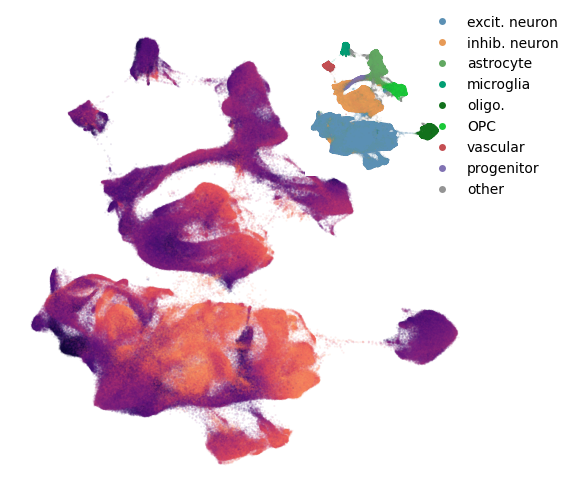

In [6]:
# main plot
fig, ax1 = plt.subplots(1,1,figsize=(5,5))

sns.scatterplot(x='umap_x', y='umap_y',  linewidth=0, s=2,alpha=0.1, data=velmeshev, hue='score', 
                palette='magma', ax=ax1, legend=None)

# add cell territories as inset
label_pal = {'ExNeu':'excit. neuron',
             'IN':'inhib. neuron',
             'AST':'astrocyte',
             'MG':'microglia',
             'OL':'oligo.',
             'OPC':'OPC',
             'VASC':'vascular',
             'GLIALPROG':'progenitor',
             'OUT':'other'
           }

plot_pal = { 'excit. neuron':'#5b90b4',
             'inhib. neuron':'#e79a56',
             'astrocyte':'#61a861',
             'microglia':'#029e73',
             'oligo.':'#12711c',
             'OPC':'#1ac938',
             'vascular':'#c44e52',
             'progenitor':'#8172b3',
             'other':'#949494'
           }

velmeshev['lineage_labels'] = velmeshev['Lineage'].map(label_pal)

#                             percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.62, 0.65, 0.28, 0.28]
ax2 = fig.add_axes([left, bottom, width, height])
g = sns.scatterplot(x='umap_x', y='umap_y',  linewidth=0, s=1,alpha=0.1, data=velmeshev, hue='lineage_labels', hue_order=plot_pal.keys(),
            palette=plot_pal, ax=ax2, legend='full')
# legend formatting
gl = g.legend(markerscale=5, frameon=False, fontsize=10, loc='right', bbox_to_anchor=(1.9,.5))
for lh in gl.legend_handles:
    lh.set_alpha(1)

# formatting
for a in (ax1, ax2):
    a.tick_params(length=0)
    a.set_yticklabels([])
    a.set_xticklabels([])
    a.set_xlabel('')
    a.set_ylabel('')
sns.despine(ax=ax1, left=True, bottom=True)
sns.despine(ax=ax2, left=True, bottom=True)

plt.tight_layout()
plt.savefig(f'OUTPUTS/velmeshev-all-cells-increasing-fdr05-{measure}_subdiv{subdiv}.png', 
            dpi=300, facecolor='white', transparent=False,  bbox_inches="tight")

### Pseudotime analysis for excitatory and glial lines

In [7]:
# get pseudotime graph for neurons
exneuro_G = calculate_graph_from_file(f'{path_to_velmeshev_data}/ex-neu-graph.tsv')
cell_time, exneuro_G = calculate_cell_time(exneuro_G, exneu_meta)
# add to metadata
exneu_meta['time'] = cell_time/np.max(cell_time)

# pseudotime for glial cells
glial_G = calculate_graph_from_file(f'{path_to_velmeshev_data}/glia-graph.tsv')
cell_time, glial_G = calculate_cell_time(glial_G, glial_meta)
# add to metadata
glial_meta['time'] = cell_time/np.max(cell_time)

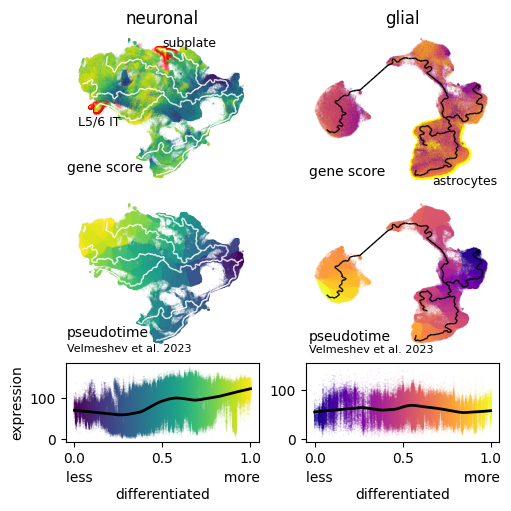

In [8]:
# PSEUDOTIME PLOTS
mosaic = """
                    AADD
                    AADD
                    BBEE
                    BBEE
                    CCFF
                    """

fig = plt.figure(layout="constrained", figsize=(5,5))
ax_dict = fig.subplot_mosaic(mosaic)

# highlight territories of subplate neurons + L5/6 neurons
sns.scatterplot(x='umap_x', y='umap_y',  linewidth=0, s=10,alpha=0.2, data=exneu_meta[exneu_meta['Cell_Type']=='SP'],
                color='red', ax=ax_dict['A'], legend=False)
sns.scatterplot(x='umap_x', y='umap_y',  linewidth=0, s=10,alpha=0.2, data=exneu_meta[exneu_meta['Cell_Type']=='L5-6-IT'],
                color='red', ax=ax_dict['A'], legend=False)

# plot hub score (total) on neuronal umap
sns.scatterplot(x='umap_x', y='umap_y',  linewidth=0, s=1,alpha=0.1, hue_norm=(10,140), data=exneu_meta, hue='score', 
                palette='viridis', ax=ax_dict['A'], legend=False)

# label subtypes
ax_dict['A'].text(0,7,'subplate', fontsize=9)
ax_dict['A'].text(-11.5,-4,'L5/6 IT', fontsize=9)

# plot pseduotime for neurons
sns.scatterplot(x='umap_x', y='umap_y',  linewidth=0, s=1,alpha=0.1, data=exneu_meta, hue='time', 
                palette='viridis', ax=ax_dict['B'], legend=False)

# plot regression of score vs time 
sns.scatterplot(x='time', y='score',  linewidth=0, s=1,alpha=0.1, data=exneu_meta[exneu_meta['score']>0], hue='time', 
                palette='viridis', ax=ax_dict['C'], legend=False)
lowess = sl.lowess(exneu_meta[exneu_meta['score']>0]['score'], exneu_meta[exneu_meta['score']>0]['time'], frac=1/3)
ax_dict['C'].plot(lowess[:,0], lowess[:,1], color='black', lw=2)

# add trajectories
pos = nx.get_node_attributes(exneuro_G,'pos')
for a in (ax_dict['A'], ax_dict['B']):
    nx.draw(exneuro_G, pos, node_color='black', linewidths=2, edge_color='white', node_size=0, ax=a)

#############################################################################################################
# now for glial cells
sns.scatterplot(x='umap_x', y='umap_y',  linewidth=0, s=10,alpha=0.2, data=glial_meta[glial_meta['Cell_Type'].isin(['Protoplasmic_astrocytes', 'Fibrous_astrocytes'])],
                color='yellow', ax=ax_dict['D'], legend=False)

# plot hub score (total) on glial umap
sns.scatterplot(x='umap_x', y='umap_y',  linewidth=0, s=1,alpha=0.1, hue_norm=(10,110),  data=glial_meta, hue='score', 
                palette='plasma', ax=ax_dict['D'], legend=False)

# label subtypes
ax_dict['D'].text(2,-12,'astrocytes', fontsize=9)
#ax_dict['D'].text(-10,-5.5,'oligo.', fontsize=10)

# plot pseduotime for glia
sns.scatterplot(x='umap_x', y='umap_y', linewidth=0, s=1, alpha=0.1, data=glial_meta, hue='time', 
                palette='plasma', ax=ax_dict['E'], legend=False)
ax_dict['B'].text(-13,-10.5,'pseudotime', fontsize=10)
ax_dict['A'].text(-13,-10.5,'gene score', fontsize=10)
ax_dict['B'].text(-13,-12.5,'Velmeshev et al. 2023', fontsize=8)

ax_dict['E'].text(-13,-10.5,'pseudotime', fontsize=10)
ax_dict['D'].text(-13,-10.5,'gene score', fontsize=10)
ax_dict['E'].text(-13,-12.5,'Velmeshev et al. 2023', fontsize=8)

# plot regression of score vs time 
sns.scatterplot(x='time', y='score',  linewidth=0, s=1,alpha=0.1, data=glial_meta[glial_meta['score']>0], hue='time', 
                palette='plasma', ax=ax_dict['F'], legend=False)
lowess = sl.lowess(glial_meta[glial_meta['score']>0]['score'], glial_meta[glial_meta['score']>0]['time'], frac=1/3)
ax_dict['F'].plot(lowess[:,0], lowess[:,1], color='black', lw=2)

# add trajectories
pos = nx.get_node_attributes(glial_G,'pos')
for a in (ax_dict['D'], ax_dict['E']):
    nx.draw(glial_G, pos, node_color='black', linewidths=2, edge_color='black', node_size=0, ax=a)

ax_dict['A'].set_title('neuronal', fontsize=12)
ax_dict['D'].set_title('glial', fontsize=12)

ax_dict['C'].set_xlabel('less                              more\ndifferentiated')
ax_dict['F'].set_xlabel('less                              more\ndifferentiated')

ax_dict['C'].set_ylabel('expression')
ax_dict['F'].set_ylabel('')

plt.savefig(f'OUTPUTS/velmeshev-subtypes-pseudotime-increasing-fdr05-{measure}_subdiv{subdiv}-SPATIAL.png', 
            dpi=300, facecolor='white', transparent=False,  bbox_inches="tight")

### Cell type enrichment plots

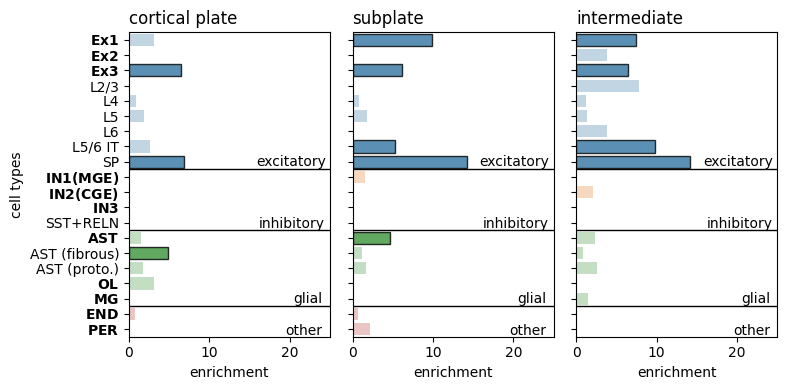

In [9]:
results_df_increasing = pd.read_csv(f'OUTPUTS/cell-lineage-enrichment-increasing-fdr05-{measure}_subdiv{subdiv}.csv')

order = ['Ex1', 'Ex2', 'Ex3',
         'L2_3', 'L4', 'L5', 'L6', 'L5_6_IT', 'SP', # excitatory lineage and branches
         'IN1', # MGE-derived
         'IN2', # CGE-derived
         'IN3', #inhibitory
         'SST_RELN', # inhib subtypes
         'AST', 'AST_FB', 'AST_PP',
         'OL', 
         'MG', # glia
         'END', 
         'PER'] #other

types = ['excitatory', 'excitatory', 'excitatory',
        'excitatory', 'excitatory', 'excitatory', 'excitatory', 'excitatory', 'excitatory',
        'inhibitory', 
         'inhibitory', 
        'inhibitory', 
        'inhibitory',
        'glial', 'glial', 'glial',
        'glial',
        'glial',
        'other', 'other']
 
names = [r"$\bf{Ex1}$", r"$\bf{Ex2}$", r"$\bf{Ex3}$",  # excitatory lineage and branches
         'L2/3', 'L4', 'L5', 'L6','L5/6 IT', 'SP',
         r"$\bf{IN1 (MGE)}$", # MGE-derived
         r"$\bf{IN2 (CGE)}$", # CGE-derived
         r"$\bf{IN3}$",#inhibitory
         'SST+RELN', 
         r"$\bf{AST}$", 'AST (fibrous)', 'AST (proto.)',
         r"$\bf{OL}$", 
         r"$\bf{MG}$", # glia
         r"$\bf{END}$", 
         r"$\bf{PER}$"] #other

type_dict = dict(zip(order, types))
results_df_increasing['type'] = results_df_increasing['cell'].map(type_dict)

palette = ['#033769', '#005891', '#6192ab', '#f1c0ac', '#e57760']

fig, ax = plt.subplots(1,3,figsize=(8,4), sharey=True, sharex=True)

for n,tissue in enumerate(results_df_increasing['tissue'].unique()[:3]):
    df = results_df_increasing[results_df_increasing['tissue']==tissue]
    sns.barplot(x=df['enrichment'], y=df['cell'], order=order, ax=ax[n], hue=df['type'], alpha=0.3, legend=False,)
    for num, patch in enumerate(ax[n].patches):
        if (df[df['cell']==order[num]]['p'].values < 0.05):
            patch.set_alpha(0.8)
            patch.set_edgecolor('black')
    ax[n].axhline(8.5, 0, 5, lw=1, c='black')
    ax[n].axhline(12.5, 0, 5, lw=1, c='black')
    ax[n].axhline(17.5, 0, 5, lw=1, c='black')
    ax[n].text(15.8, 8.3, 'excitatory', fontsize=10)
    ax[n].text(16.2, 12.35, 'inhibitory', fontsize=10)
    ax[n].text(20.5, 17.3, 'glial', fontsize=10)
    ax[n].text(19.5, 19.4, 'other', fontsize=10)
    ax[n].set_xlim(0,25)
    
ax[0].set_title('cortical plate', loc='left', fontsize=12)
ax[1].set_title('subplate', loc='left', fontsize=12)
ax[2].set_title('intermediate', loc='left', fontsize=12)

ax[0].set_yticks(np.arange(20))
ax[0].set_yticklabels(names)
ax[0].set_ylabel(r"cell types", fontsize=10)
#ax[0].tick_params('y', pad=60)
plt.tight_layout()
plt.savefig(f'OUTPUTS/cell-lineage-enrichment-increasing-fdr05-{measure}_subdiv{subdiv}.png',
           dpi=300, facecolor='white', transparent=False,  bbox_inches="tight")